### Random Forest Model

In [1]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

In [3]:
# Missing Values
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna(col.mode()[0]))

# Remove duplicates
df = df.drop_duplicates()

#One Hot Encoding
df['genres'] = df['genres'].fillna('Unknown') # for genres that are empty just call them Unknown

df['genres'] = df['genres'].apply(lambda x: x.split(', '))

unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
  df[genre] = df['genres'].apply(lambda genres: int(genre in genres))

df = df.drop('genres', axis=1)

df.to_csv('TMDB_tv_dataset_v3.csv', index=False)

list = df.select_dtypes(include=['object']).columns.tolist()
encode_cols =['original_language','type', 'status','created_by','networks','origin_country','production_companies']

# Creating one-hot encoded columns for original_language
top_20_original_language = df['original_language'].value_counts(ascending = False).head(20).index.tolist()
for i in top_20_original_language:
    name = 'original-language_' + i
    df[name] = np.where(df['original_language'] == i, 1, 0)

# Removing the original_language column from df and encode_cols
df.drop(columns = ['original_language'], inplace = True)
encode_cols.remove('original_language')
df.columns

# Creating a list of the top 10 values in the created_by column
top_10_created_by = df['created_by'].value_counts(ascending = False).head(10).index.tolist()
# Creating one-hot encoded columns for created_by
for i in top_10_created_by:
    name = 'created-by_' + i
    df[name] = np.where(df['created_by'] == i, 1, 0)

# Removing the created_by column from df and encode_cols
df.drop(columns = ['created_by'], inplace = True)
encode_cols.remove('created_by')

# Creating a list of the top 11 values in the networks column
top_11_networks = df['networks'].value_counts(ascending = False).head(11).index.tolist()

# Creating one-hot encoded columns for networks
for i in top_11_networks:
    name = 'networks_' + i
    df[name] = np.where(df['networks'] == i, 1, 0)

# Removing the networks column from df and encode_cols
df.drop(columns = ['networks'], inplace = True)
encode_cols.remove('networks')

# Creating a list of the top 10 values in the origin_country column
top_26_origin_country = df['origin_country'].value_counts(ascending = False).head(26).index.tolist()

one_hot_encoded_origin_country = pd.DataFrame() # start with an empty dataframe

for i in top_26_origin_country:
    one_hot_encoded_origin_country['origin-country_' + i] = np.where(df['origin_country'] == i, 1, 0)

# the we can concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_origin_country], axis=1)

# Removing the origin_country column from df and encode_cols
df.drop(columns = ['origin_country'], inplace = True)
encode_cols.remove('origin_country')

# Creating a list of the top 10 values in the production_companies column
top_10_production_companies = df['production_companies'].value_counts(ascending = False).head(10).index.tolist()

one_hot_encoded_production_companies = pd.DataFrame() # start with an empty dataframe

for i in top_26_origin_country:
    one_hot_encoded_production_companies['production-companies_' + i] = np.where(df['production_companies'] == i, 1, 0)

# the we can concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_production_companies], axis=1)

# Removing the production_companies column from df and encode_cols
df.drop(columns = ['production_companies'], inplace = True)
encode_cols.remove('production_companies')

# One-hot encoding remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname+'')
    df = df.join(df_encoded)

# Removing remaining original cols from df
df.drop(columns=encode_cols,axis=1,inplace=True)


In [4]:
# Converting first_air_date and last_air_date columns to DateTime referring to https://www.youtube.com/watch?v=f7LODKIjtaA
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format = '%Y-%m-%d')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format = '%Y-%m-%d' )
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

# Creating a function to create seasons for each month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'
    
# Creating a column with the seasons for first_air_date
df['first_air_date_season'] = df['first_air_date'].apply(get_season)
df['first_air_date_season']

# Creating columns for first_air_date_season as boolean values
df['first_air_date_winter'] = df['first_air_date_season'] == 'WINTER'
df['first_air_date_spring'] = df['first_air_date_season'] == 'SPRING'
df['first_air_date_summer'] = df['first_air_date_season'] == 'SUMMER'
df['first_air_date_fall'] = df['first_air_date_season'] == 'FALL'

# Repeating same process for last_air_date
df['last_air_date_season'] = df['last_air_date'].apply(get_season)
df['last_air_date_season']


datetime64[ns]
datetime64[ns]


0          SPRING
1          WINTER
2          SUMMER
3            FALL
4            FALL
           ...   
168412    UNKNOWN
168416    UNKNOWN
168418    UNKNOWN
168419    UNKNOWN
168420    UNKNOWN
Name: last_air_date_season, Length: 168593, dtype: object

In [5]:
# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

# List of log-transformed numerical columns
numerical_columns_log = [col + '_log' for col in numerical_columns]

# Display summary statistics for log-transformed columns
print(df[numerical_columns_log].describe())

        id              name  number_of_seasons  number_of_episodes  \
0   1399.0   Game of Thrones                8.0                73.0   
1  71446.0       Money Heist                3.0                41.0   
2  66732.0   Stranger Things                4.0                34.0   
3   1402.0  The Walking Dead               11.0               177.0   
4  63174.0           Lucifer                6.0                93.0   

   vote_count  vote_average  \
0     21857.0         8.442   
1     17836.0         8.257   
2     16161.0         8.624   
3     15432.0         8.121   
4     13870.0         8.486   

                                            overview  adult  \
0  Seven noble families fight for control of the ...  False   
1  To carry out the biggest heist in history, a m...  False   
2  When a young boy vanishes, a small town uncove...  False   
3  Sheriff's deputy Rick Grimes awakens from a co...  False   
4  Bored and unhappy as the Lord of Hell, Lucifer...  False   

       

In [6]:
# Winsorize
from scipy.stats.mstats import winsorize

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.95  # 95th percentile

# Winsorize each numerical column and add it back to the DataFrame
for col in numerical_columns:
    df[col + '_winsorized'] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

# Winsorize each log-transformed numerical column and add it back to the DataFrame
for col in numerical_columns_log:
    df[col + '_winsorized'] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

In [7]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling and add columns with '_norm' suffix to the DataFrame
df[[col + '_norm' for col in numeric_columns]] = scaler.fit_transform(df[numeric_columns])

# Display the updated DataFrame to confirm new normalized columns
print(df.head())

        id              name  number_of_seasons  number_of_episodes  \
0   1399.0   Game of Thrones                8.0                73.0   
1  71446.0       Money Heist                3.0                41.0   
2  66732.0   Stranger Things                4.0                34.0   
3   1402.0  The Walking Dead               11.0               177.0   
4  63174.0           Lucifer                6.0                93.0   

   vote_count  vote_average  \
0     21857.0         8.442   
1     17836.0         8.257   
2     16161.0         8.624   
3     15432.0         8.121   
4     13870.0         8.486   

                                            overview  adult  \
0  Seven noble families fight for control of the ...  False   
1  To carry out the biggest heist in history, a m...  False   
2  When a young boy vanishes, a small town uncove...  False   
3  Sheriff's deputy Rick Grimes awakens from a co...  False   
4  Bored and unhappy as the Lord of Hell, Lucifer...  False   

       

/var/folders/n4/c3jxqdvx2l15c7ghrhjmd95m0000gn/T/ipykernel_71057/3659227612.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[col + '_norm' for col in numeric_columns]] = scaler.fit_transform(df[numeric_columns])
/var/folders/n4/c3jxqdvx2l15c7ghrhjmd95m0000gn/T/ipykernel_71057/3659227612.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[col + '_norm' for col in numeric_columns]] = scaler.fit_transform(df[numeric_columns])
/var/folders/n4/c3jxqdvx2l15c7ghrhjmd95m0000gn/T/ipykernel_71057/3659227612.py:11: Performance

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [14]:
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'episode_run_time']]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with regular dataset, 4 numerical features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with regular dataset, 4 numerical features:
Train MAE: 2.4965
Train RMSE: 18.7425
Train R^2: 0.8101
Test MAE: 5.1778
Test RMSE: 35.1739
Test R^2: 0.1352


In [17]:
df['popularity'] = df['popularity'].fillna(df['popularity'].mean())
df['popularity_log'] = df['popularity_log'].fillna(df['popularity_log'].mean())
y.isnull().sum()

1534

In [18]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 'vote_average_log', 'episode_run_time']]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Log Transformation, 4 features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Log Transformation, 4 features:
Train MAE: 0.2263
Train RMSE: 0.3712
Train R^2: 0.8268
Test MAE: 0.3376
Test RMSE: 0.5560
Test R^2: 0.6090


In [19]:
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 
        'episode_run_time', 'Action & Adventure', 'Animation', 'Comedy', 'Crime', 
        'Documentary', 'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 
        'Mystery', 'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 
        'Talk', 'Unknown', 'War & Politics', 'Western']]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Genres Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Genres Features:
Train MAE: 2.2744
Train RMSE: 18.0953
Train R^2: 0.8230
Test MAE: 5.1625
Test RMSE: 35.3309
Test R^2: 0.1275


In [21]:

X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 'Action & Adventure', 
        'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
        'History', 'Kids', 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
        'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics', 
        'Western', 'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_ar', 'original-language_da', 
        'original-language_cn', 'original-language_th', 'original-language_tr', 
        'original-language_it', 'original-language_hi', 'original-language_sv', 
        'original-language_cs', 'original-language_no', 'created-by_Shotaro Ishinomori', 
        'created-by_John de Mol', 'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 'created-by_Yang Li-Hua', 
        'created-by_Joseph Barbera, William Hanna', 'created-by_R.J. Nuevas', 
        'created-by_Mark Burnett', 'networks_BBC One', 'networks_YouTube', 
        'networks_Netflix', 'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 
        'networks_NBC', 'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_ZDF', 'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 'origin-country_CA', 
        'origin-country_FR', 'origin-country_AU', 'origin-country_BR', 'origin-country_NL', 
        'origin-country_RU', 'origin-country_ES', 'origin-country_TH', 'origin-country_HK', 
        'origin-country_IN', 'origin-country_DK', 'origin-country_PH', 'origin-country_IT', 
        'origin-country_TR', 'origin-country_SE', 'origin-country_NO', 'origin-country_TW', 
        'origin-country_BE', 'origin-country_CZ', 'origin-country_MX', 'production-companies_US', 
        'production-companies_JP', 'production-companies_GB', 'production-companies_CN', 
        'production-companies_DE', 'production-companies_KR', 'production-companies_CA', 
        'production-companies_FR', 'production-companies_AU', 'production-companies_BR', 
        'production-companies_NL', 'production-companies_RU', 'production-companies_ES', 
        'production-companies_TH', 'production-companies_HK', 'production-companies_IN', 
        'production-companies_DK', 'production-companies_PH', 'production-companies_IT', 
        'production-companies_TR', 'production-companies_SE', 'production-companies_NO', 
        'production-companies_TW', 'production-companies_BE', 'production-companies_CZ', 
        'production-companies_MX']]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Log Transformation + One-Hot Encoded Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Log Transformation + One-Hot Encoded Features:
Train MAE: 0.1311
Train RMSE: 0.2210
Train R^2: 0.9386
Test MAE: 0.3043
Test RMSE: 0.5144
Test R^2: 0.6654


In [24]:
"""
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the model with potential regularization parameters
rf_model = RandomForestRegressor(random_state=42)

# Set up parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate best estimator
best_rf_model = grid_search.best_estimator_
train_predictions = best_rf_model.predict(X_train)
test_predictions = best_rf_model.predict(X_test)

# Calculate updated metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_r2 = r2_score(y_train, train_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print("Results with Tuned Random Forest:")
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')
"""

'\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\n\n# Define the model with potential regularization parameters\nrf_model = RandomForestRegressor(random_state=42)\n\n# Set up parameter grid for tuning\nparam_grid = {\n    \'n_estimators\': [50, 100],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 10],\n    \'min_samples_leaf\': [1, 4]\n}\n\n# Perform Grid Search with Cross-Validation\ngrid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\n# Evaluate best estimator\nbest_rf_model = grid_search.best_estimator_\ntrain_predictions = best_rf_model.predict(X_train)\ntest_predictions = best_rf_model.predict(X_test)\n\n# Calculate updated metrics\ntrain_mae = mean_absolute_error(y_train, train_predictions)\ntrain_rmse = np.sqrt(mean_squar

In [20]:
"""
# Print the best parameters found
print("Best Parameters for Random Forest:", grid_search.best_params_)
"""

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [22]:
# Define features and target variable
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 'Action & Adventure', 
        'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
        'History', 'Kids', 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
        'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics', 
        'Western', 'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_ar', 'original-language_da', 
        'original-language_cn', 'original-language_th', 'original-language_tr', 
        'original-language_it', 'original-language_hi', 'original-language_sv', 
        'original-language_cs', 'original-language_no', 'created-by_Shotaro Ishinomori', 
        'created-by_John de Mol', 'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 'created-by_Yang Li-Hua', 
        'created-by_Joseph Barbera, William Hanna', 'created-by_R.J. Nuevas', 
        'created-by_Mark Burnett', 'networks_BBC One', 'networks_YouTube', 
        'networks_Netflix', 'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 
        'networks_NBC', 'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_ZDF', 'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 'origin-country_CA', 
        'origin-country_FR', 'origin-country_AU', 'origin-country_BR', 'origin-country_NL', 
        'origin-country_RU', 'origin-country_ES', 'origin-country_TH', 'origin-country_HK', 
        'origin-country_IN', 'origin-country_DK', 'origin-country_PH', 'origin-country_IT', 
        'origin-country_TR', 'origin-country_SE', 'origin-country_NO', 'origin-country_TW', 
        'origin-country_BE', 'origin-country_CZ', 'origin-country_MX', 'production-companies_US', 
        'production-companies_JP', 'production-companies_GB', 'production-companies_CN', 
        'production-companies_DE', 'production-companies_KR', 'production-companies_CA', 
        'production-companies_FR', 'production-companies_AU', 'production-companies_BR', 
        'production-companies_NL', 'production-companies_RU', 'production-companies_ES', 
        'production-companies_TH', 'production-companies_HK', 'production-companies_IN', 
        'production-companies_DK', 'production-companies_PH', 'production-companies_IT', 
        'production-companies_TR', 'production-companies_SE', 'production-companies_NO', 
        'production-companies_TW', 'production-companies_BE', 'production-companies_CZ', 
        'production-companies_MX']]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor with specified parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=4, 
                           min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Grid Search Best Parameters (Log Transformation + One-Hot Encoded Features):")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Grid Search Best Parameters (Log Transformation + One-Hot Encoded Features):
Train MAE: 0.2354
Train RMSE: 0.3866
Train R^2: 0.8122
Test MAE: 0.2940
Test RMSE: 0.4991
Test R^2: 0.6850


/var/folders/n4/c3jxqdvx2l15c7ghrhjmd95m0000gn/T/ipykernel_31029/3056937716.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Importance', data=features_df, palette="viridis")


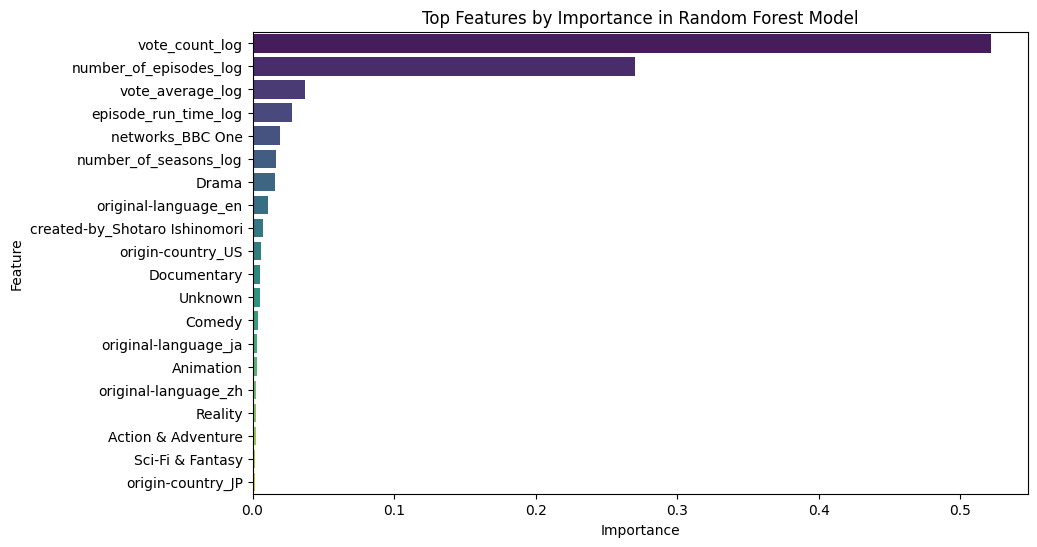

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False).head(20)  # Top 10 features

# Plot the minimal depth approximation (importance) distribution
plt.figure(figsize=(10, 6))
sns.barplot(y='Feature', x='Importance', data=features_df, palette="viridis")
plt.title("Top Features by Importance in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


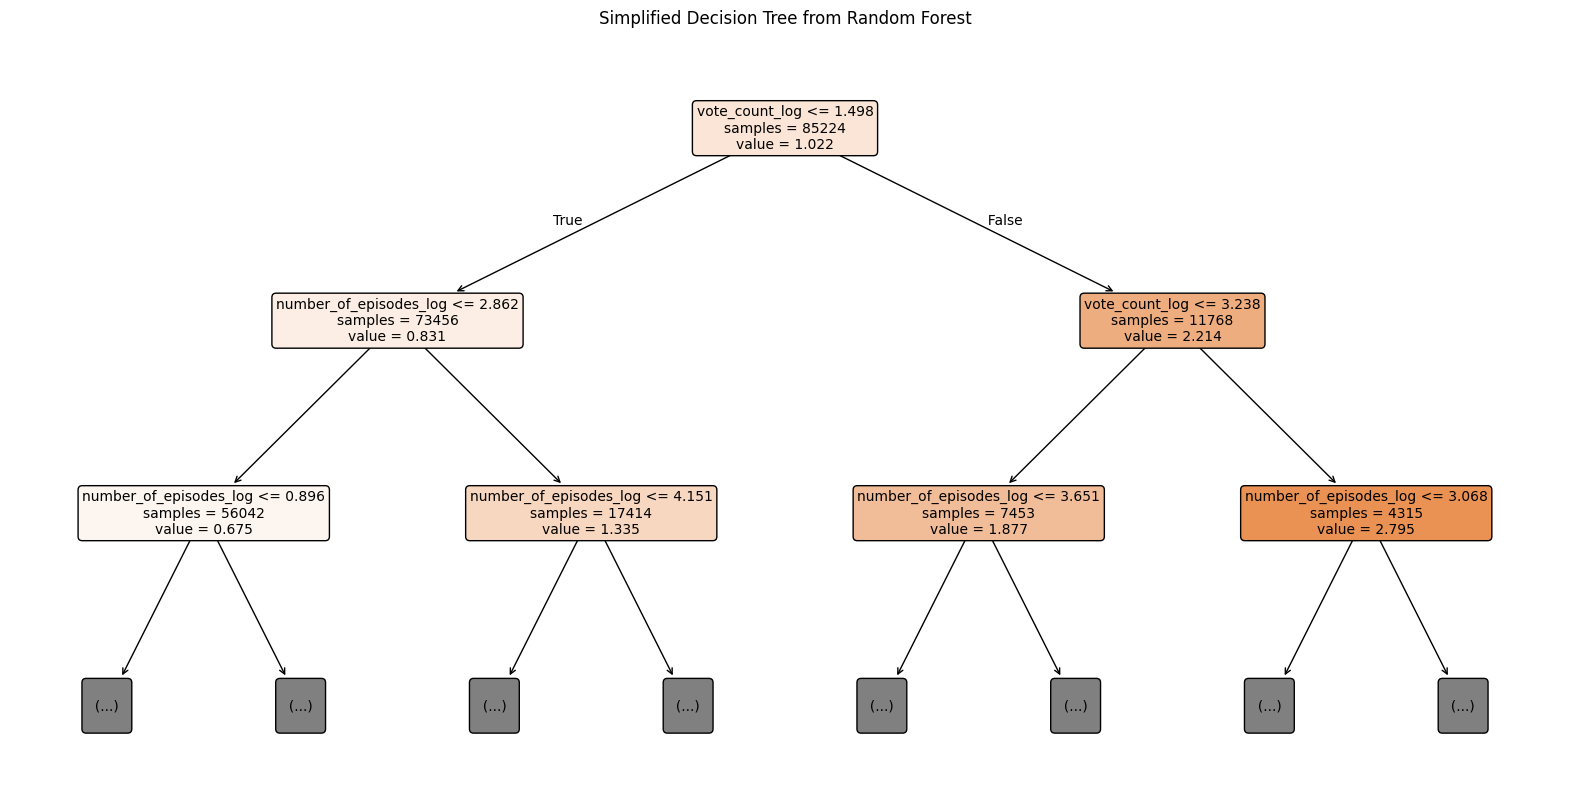

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

max_depth = 2
single_tree = rf.estimators_[10]  

# Plot the tree with simplified node labels
plt.figure(figsize=(20, 10))
plot_tree(single_tree, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=max_depth,
          impurity=False,          # Hide impurity (squared error for regression trees)
          proportion=False)         # Hide samples proportion
plt.title("Simplified Decision Tree from Random Forest")
plt.show()


### Decision Tree Graph (by Random Forest) without Logarithmic Values

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features and target variable
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 
        'vote_average', 'episode_run_time', 'Action & Adventure', 
        'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
        'History', 'Kids', 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
        'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics', 
        'Western', 'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_ar', 'original-language_da', 
        'original-language_cn', 'original-language_th', 'original-language_tr', 
        'original-language_it', 'original-language_hi', 'original-language_sv', 
        'original-language_cs', 'original-language_no', 'created-by_Shotaro Ishinomori', 
        'created-by_John de Mol', 'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 'created-by_Yang Li-Hua', 
        'created-by_Joseph Barbera, William Hanna', 'created-by_R.J. Nuevas', 
        'created-by_Mark Burnett', 'networks_BBC One', 'networks_YouTube', 
        'networks_Netflix', 'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 
        'networks_NBC', 'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_ZDF', 'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 'origin-country_CA', 
        'origin-country_FR', 'origin-country_AU', 'origin-country_BR', 'origin-country_NL', 
        'origin-country_RU', 'origin-country_ES', 'origin-country_TH', 'origin-country_HK', 
        'origin-country_IN', 'origin-country_DK', 'origin-country_PH', 'origin-country_IT', 
        'origin-country_TR', 'origin-country_SE', 'origin-country_NO', 'origin-country_TW', 
        'origin-country_BE', 'origin-country_CZ', 'origin-country_MX', 'production-companies_US', 
        'production-companies_JP', 'production-companies_GB', 'production-companies_CN', 
        'production-companies_DE', 'production-companies_KR', 'production-companies_CA', 
        'production-companies_FR', 'production-companies_AU', 'production-companies_BR', 
        'production-companies_NL', 'production-companies_RU', 'production-companies_ES', 
        'production-companies_TH', 'production-companies_HK', 'production-companies_IN', 
        'production-companies_DK', 'production-companies_PH', 'production-companies_IT', 
        'production-companies_TR', 'production-companies_SE', 'production-companies_NO', 
        'production-companies_TW', 'production-companies_BE', 'production-companies_CZ', 
        'production-companies_MX']]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor with specified parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=4, 
                           min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Grid Search Best Parameters + Non-Log Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Grid Search Best Parameters + Non-Log Features:
Train MAE: 1.2082
Train MSE: 6.1669
Train R^2: 0.8004
Test MAE: 1.5080
Test MSE: 10.0115
Test R^2: 0.6748


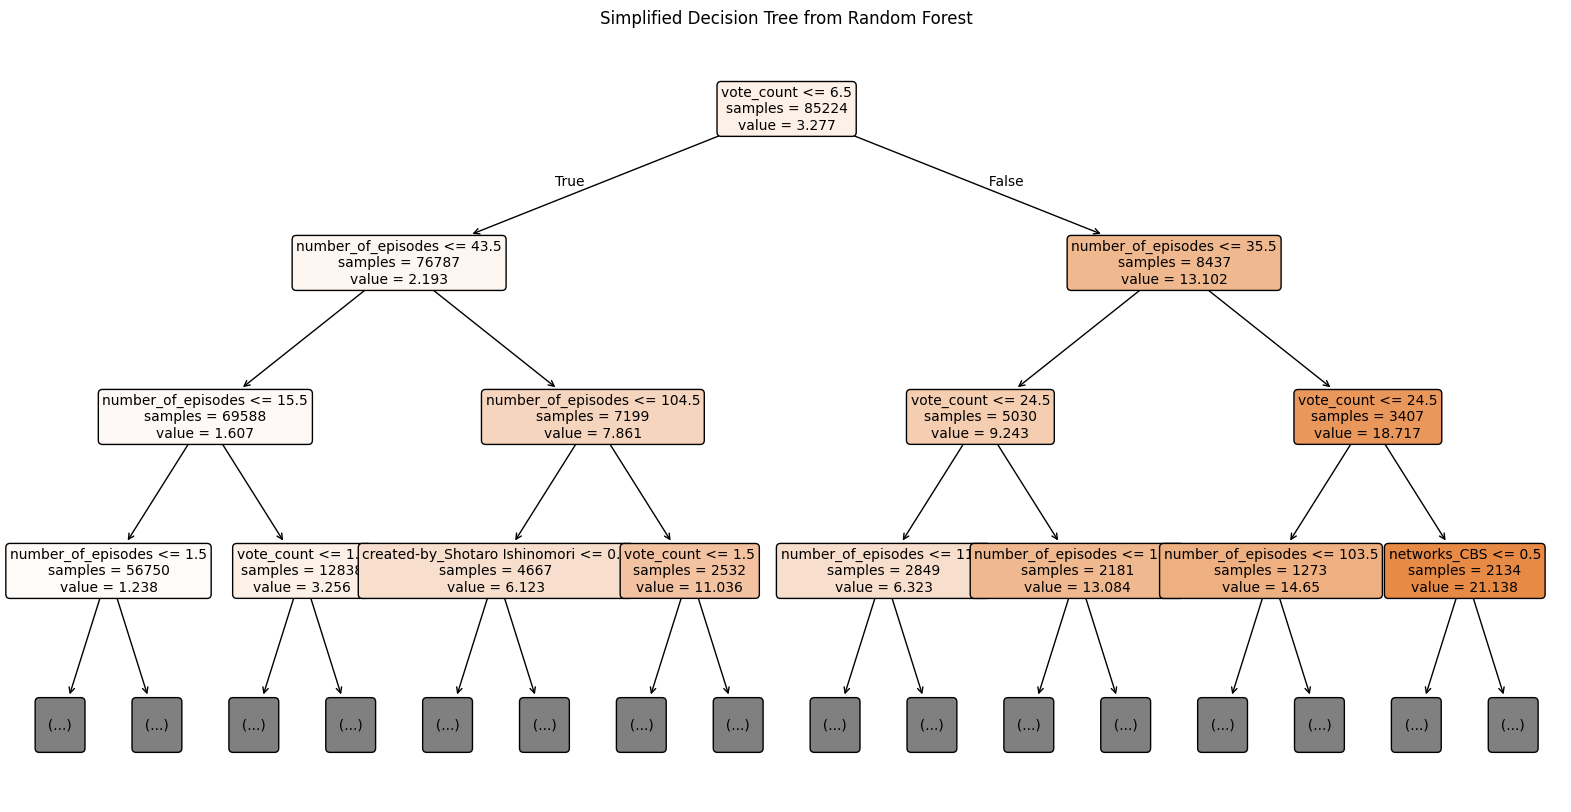

In [41]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

max_depth = 3
single_tree = rf.estimators_[10]  

# Plot the tree with simplified node labels
plt.figure(figsize=(20, 10))
plot_tree(single_tree, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=max_depth,
          impurity=False,          # Hide impurity (squared error for regression trees)
          proportion=False)         # Hide samples proportion
plt.title("Simplified Decision Tree from Random Forest")
plt.show()


In [43]:
import numpy as np
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features and target variable
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 
        'vote_average', 'episode_run_time_log', 'Action & Adventure', 
        'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
        'History', 'Kids', 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
        'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 'War & Politics', 
        'Western', 'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_ar', 'original-language_da', 
        'original-language_cn', 'original-language_th', 'original-language_tr', 
        'original-language_it', 'original-language_hi', 'original-language_sv', 
        'original-language_cs', 'original-language_no', 'created-by_Shotaro Ishinomori', 
        'created-by_John de Mol', 'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 'created-by_Yang Li-Hua', 
        'created-by_Joseph Barbera, William Hanna', 'created-by_R.J. Nuevas', 
        'created-by_Mark Burnett', 'networks_BBC One', 'networks_YouTube', 
        'networks_Netflix', 'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 
        'networks_NBC', 'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_ZDF', 'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 'origin-country_CA', 
        'origin-country_FR', 'origin-country_AU', 'origin-country_BR', 'origin-country_NL', 
        'origin-country_RU', 'origin-country_ES', 'origin-country_TH', 'origin-country_HK', 
        'origin-country_IN', 'origin-country_DK', 'origin-country_PH', 'origin-country_IT', 
        'origin-country_TR', 'origin-country_SE', 'origin-country_NO', 'origin-country_TW', 
        'origin-country_BE', 'origin-country_CZ', 'origin-country_MX', 'production-companies_US', 
        'production-companies_JP', 'production-companies_GB', 'production-companies_CN', 
        'production-companies_DE', 'production-companies_KR', 'production-companies_CA', 
        'production-companies_FR', 'production-companies_AU', 'production-companies_BR', 
        'production-companies_NL', 'production-companies_RU', 'production-companies_ES', 
        'production-companies_TH', 'production-companies_HK', 'production-companies_IN', 
        'production-companies_DK', 'production-companies_PH', 'production-companies_IT', 
        'production-companies_TR', 'production-companies_SE', 'production-companies_NO', 
        'production-companies_TW', 'production-companies_BE', 'production-companies_CZ', 
        'production-companies_MX']]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical features by their index
cat_features_indices = [0, 2, 5]  # Example indices; adjust these based on your dataset if necessary

# Initialize Pool objects for training and testing
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features_indices)
test_pool = Pool(data=X_test, cat_features=cat_features_indices)

# Specify the training parameters
model = CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.1, loss_function='RMSE', random_seed=42, silent=True)

# Train the model
model.fit(train_pool)

# Make predictions
preds_train = model.predict(train_pool)
preds_test = model.predict(test_pool)

# Evaluate model performance
train_mae = mean_absolute_error(y_train, preds_train)
train_mse = mean_squared_error(y_train, preds_train)
train_r2 = r2_score(y_train, preds_train)

test_mae = mean_absolute_error(y_test, preds_test)
test_mse = mean_squared_error(y_test, preds_test)
test_r2 = r2_score(y_test, preds_test)

# Print evaluation metrics
print("CatBoost Regressor Results:")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R^2: {test_r2:.4f}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject